In [211]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [212]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
sns.set_context('poster')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [214]:
df = sf.parse_orffinder_fasta(os.path.join('orffinder_tmp', 'BX548174.orffinder.fa'))
df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,len_aa3,rast_left,rast_right
0,ORF1_BX548174.1:2043:4382,BX548174.1,2043,4382,2043,4382,+,MIDSSSNNTYDVNESLKVENLTRDDYEEICKRLGRKPNRTELGMFG...,2340,779,2340,2044,4383
1,ORF2_BX548174.1:13470:14525,BX548174.1,13470,14525,13470,14525,+,MDDEIKSYFNNFDFSKNFKLKDDISFEKVLNNQFKEYVIKSYKVLS...,1056,351,1056,13471,14526
2,ORF3_BX548174.1:44304:46964,BX548174.1,44304,46964,44304,46964,+,MKSQTKNTPITGDEIRKEFLNFYHEKLHKIIPSASLIPDDPTVMLT...,2661,886,2661,44305,46965
3,ORF4_BX548174.1:72447:74375,BX548174.1,72447,74375,72447,74375,+,MNNAKNLKIKQIDKKNISFKELSLIKNIIFWVDIIPGDQTQKNAIF...,1929,642,1929,72448,74376
4,ORF5_BX548174.1:86775:87959,BX548174.1,86775,87959,86775,87959,+,MKSIKKPIVIVGAGFGGMTVASNLKELNPSLPILVVDSEAKFIFKP...,1185,394,1185,86776,87960


In [215]:
df.loc[df.len_aa3 != df.len_nn]

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,len_aa3,rast_left,rast_right


In [216]:
gdf = sf.load_genome('MED4')

In [217]:
gdf.head()

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence,genome,left,right
0,MED4,PMED4_0001,fig|1218.84.peg.1,peg,MED4_174_1331,174,1331,+,DNA polymerase III beta subunit (EC 2.7.7.7),NaN,FIG00066425,isu;DNA-replication isu;DNA_replication_cluster_1,atggagattgtttgtaatcaaaatgaatttaattatgctattcaat...,MEIVCNQNEFNYAIQLVSKAVASRPTHPILANLLLTADQGTNKISL...,MED4,174,1331
1,MED4,PMED4_0002,fig|1218.84.peg.2,peg,MED4_1333_2040,1333,2040,+,hypothetical protein,NaN,NaN,NaN,ttgaaattaccaaaagaatttttattaagtgaattattaagacata...,MKLPKEFLLSELLRHNVKGNATLNYGKGENVWMHPPVHRILGWYSR...,MED4,1333,2040
2,MED4,PMED4_0003,fig|1218.84.peg.3,peg,MED4_2044_4383,2044,4383,+,"Phosphoribosylformylglycinamidine synthase, sy...",NaN,FIG01303876,icw(1);De_Novo_Purine_Biosynthesis,atgatagattcttcaagtaacaatacttatgatgttaatgaatcac...,MIDSSSNNTYDVNESLKVENLTRDDYEEICKRLGRKPNRTELGMFG...,MED4,2044,4383
3,MED4,PMED4_0004,fig|1218.84.peg.4,peg,MED4_4430_5890,4430,5890,+,Amidophosphoribosyltransferase (EC 2.4.2.14),NaN,FIG00000179,isu;YgfZ isu;De_Novo_Purine_Biosynthesis,atgtgtggaattgttggaattgtttcttgtgatgatgtaaatcaac...,MCGIVGIVSCDDVNQQIYDSLLLLQHRGQDSTGIATMENTVFHIHK...,MED4,4430,5890
4,MED4,PMED4_0005,fig|1218.84.peg.5,peg,MED4_8259_5887,8259,5887,-,DNA gyrase subunit A (EC 5.99.1.3),NaN,FIG00000080,idu(1);DNA_gyrase_subunits idu(1);DNA_topoisom...,atgagtgtgataataggacgtgctttacctgatgcaagagatggac...,MSVIIGRALPDARDGLKPVQRRILFAMHELGLTPDRPFRKCARVVG...,MED4,5887,8259


In [218]:
df = sf.add_gene_annotation_to_sorf_df(df, gdf)

In [219]:
df = sf.add_overlapping_genes(df, gdf)

In [220]:
df = sf.add_overlap_type(df)

In [221]:
df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'type', 'start_rast', 'stop_rast', 'function', 'figfam',
       'nucleotide_sequence', 'aa_sequence', 'genome', 'left_rast',
       'right_rast', 'overlapping_gene_id', 'overlap_type'],
      dtype='object')

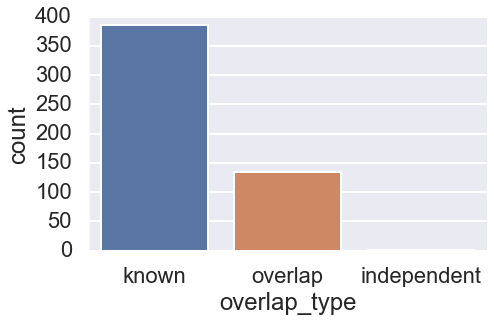

In [222]:
sns.catplot(data=df, x='overlap_type', kind='count', aspect=1.4)

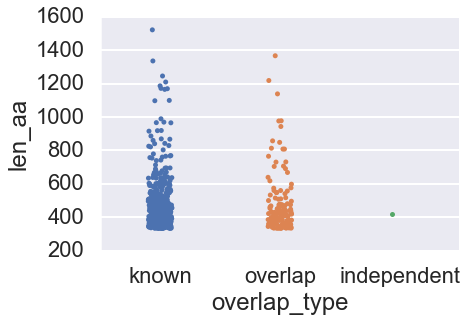

In [223]:
sns.catplot(data=df, x='overlap_type', y='len_aa', aspect=1.4)

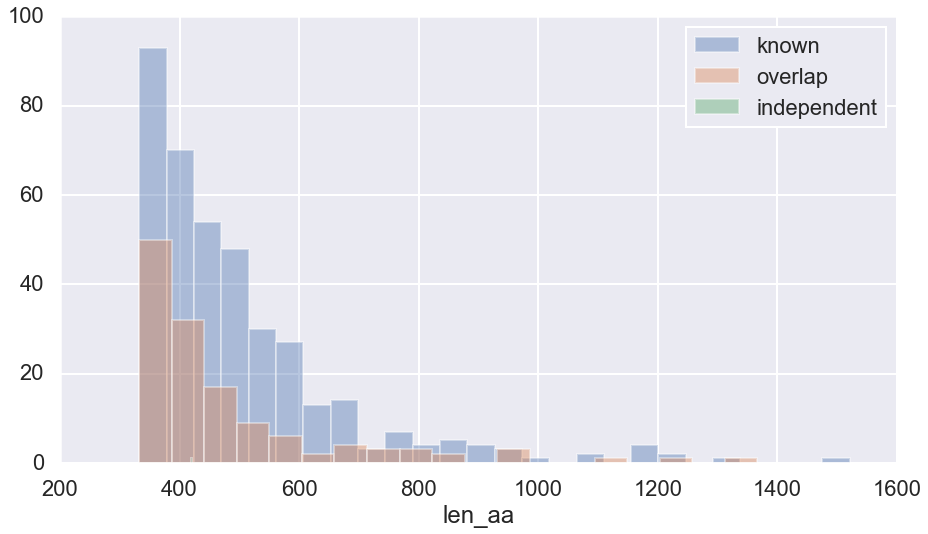

In [224]:
for i in df.overlap_type.unique():
    sns.distplot(df.loc[df.overlap_type == i].len_aa, label=i, kde=False)
plt.legend()

In [225]:
sf.get_accession('MIT0604')

'CP007753'

In [226]:
metadf1 = pd.read_excel(os.path.join('data', 'metadata_pro_biller.xlsx'), sheet_name='Sheet1')
metadf2 = pd.read_excel(os.path.join('data', 'metadata_pro_biller.xlsx'), sheet_name='Sheet2')


In [227]:
metadf2.columns

Index(['Strain', 'Clade', 'Assembly size (bp)', '%GC', 'No. contigs',
       'N50 (bp)', 'No. coding sequences', 'NCBI accession'],
      dtype='object')

In [228]:
genome = 'GP2'

In [229]:
metadf1.loc[metadf1.Name == genome, 'NCBI accession'].unique(), metadf2.loc[metadf2.Strain == genome, 'NCBI accession'].unique()

(array([], dtype=object), array(['JNAH00000000'], dtype=object))

In [230]:
metadf2.head()

,Strain,Clade,Assembly size (bp),%GC,No. contigs,N50 (bp),No. coding sequences,NCBI accession
0,EQPAC1,HLI,1654739,30.8,8,328627,1954,JNAG00000000
1,GP2,HLII,1624310,31.2,11,416038,1884,JNAH00000000
2,MIT0604,HLII,1780061,31.2,1,1780061,2085,CP007753
3,MIT9107,HLII,1699937,31.0,13,170362,1991,JNAI00000000
4,MIT9116,HLII,1685398,31.0,22,117620,1972,JNAJ00000000
